# Mindestanforderungen
- Allgemeines: Die Verarbeitung von Bildern muss in Echtzeit stattfinden --> Ziel: > 20 FPS für reine Verarbeitung ohne Anzeige)  Prozessor, Grafikkarte, Arbeitsspeicher
- Allgemeines: Beschleunigen Sie die Verarbeitung durch weitere Maßnahmen (bspw. Erkennung der Spurmarkierung in den ersten Frames, Tracking der Spurmarkierung in weiteren Frames solange, bis sich Spurmarkierungspositionen zu stark ändern)  mind. eine Maßnahme im Projekt verwenden
- Allgemeines: relevante Spurmarkierungen werden in den Udacity-Bildern und im Video „project_video“ durchgehend erkannt
* * *
*Imports*

In [31]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os
import glob

## Segmentierung des Bildes
 schränken Sie das Bild auf den Bereich ein, in dem sich die Spurmarkierungen befinden

In [32]:
# TODO: Implementieren Sie hier Ihre Lösung für die Segmentierung des Bildes
# Lade das Bild
image = cv.imread('img/Udacity/image002.jpg')

# Definiere den Bereich für den Himmel und die Büsche (als Beispiel)
lower_blue = np.array([90, 80, 80])  # Untere Grenze für Blautöne
upper_blue = np.array([130, 255, 255])  # Obere Grenze für Blautöne

# Wandle das Bild in den HSV-Farbraum um
hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

# Erstelle eine Maske, um den Bereich außerhalb des gewünschten Bereichs zu maskieren
mask = cv.inRange(hsv, lower_blue, upper_blue)

# Wend die Maske auf das ursprüngliche Bild an
result = cv.bitwise_and(image, image, mask=mask)

# Zeige das Ergebnisbild
cv.imshow('Result', result)

## Vorverarbeitung
Führen Sie eine Kamerakalibrierung (für Udacity-Bildquellen) und die Perspektivtransformation durch.

Der Code wurde teilweise aus https://learnopencv.com/camera-calibration-using-opencv/ und https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html entnommen und wurde an das Scenario angepasst.


### Berechne Kalibrationsparameter
Zuerst werden die Kalibabrationsparameter anhand der Bilder in dem Ordner ./img/Udacity/calib berechnet. 
Die Parameter werden in "calibration.npz" gespeichert.
Die gefundenen Schachbrettkanten werden markiert und angezeigt

Camera matrix : 

[[1.15694035e+03 0.00000000e+00 6.65948596e+02]
 [0.00000000e+00 1.15213869e+03 3.88785179e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 

[[-2.37636622e-01 -8.54129116e-02 -7.90955961e-04 -1.15908729e-04
   1.05741272e-01]]
rvecs : 

(array([[-0.00179064],
       [ 0.03812018],
       [-1.5763435 ]]), array([[-0.48405044],
       [ 0.51767359],
       [-1.50240484]]), array([[-0.30229087],
       [-0.40140136],
       [-1.55981221]]), array([[ 0.53294848],
       [ 0.45988482],
       [-1.49583715]]), array([[-0.3175498 ],
       [ 0.28680019],
       [-1.55283074]]), array([[-0.23160664],
       [ 0.37005869],
       [-1.49312567]]), array([[ 0.18237168],
       [ 0.09336824],
       [-1.56759397]]), array([[ 0.36333457],
       [-0.39495137],
       [-1.51868984]]), array([[ 0.44991665],
       [-0.35801399],
       [-1.5375139 ]]), array([[ 0.39905095],
       [-0.32944338],
       [-1.59723025]]), array([[ 0.22194201],
       [ 0.12216894],
       

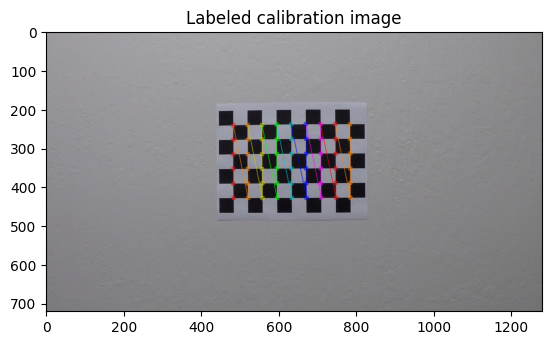

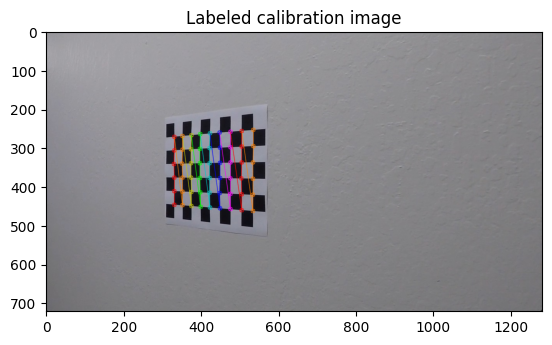

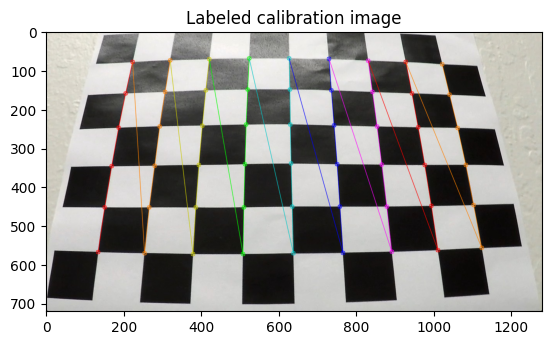

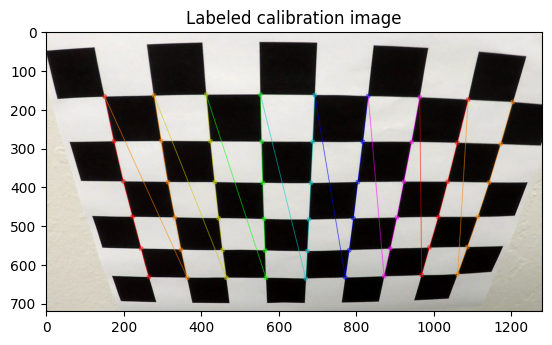

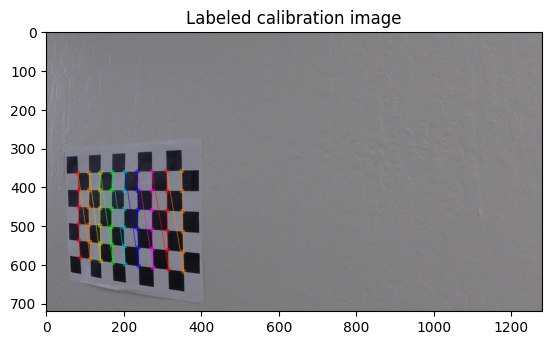

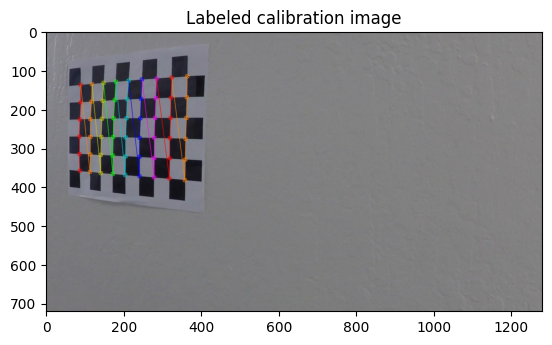

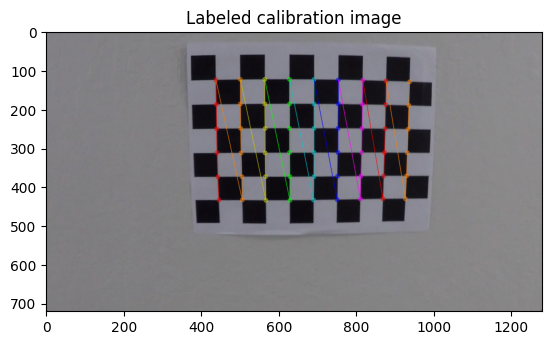

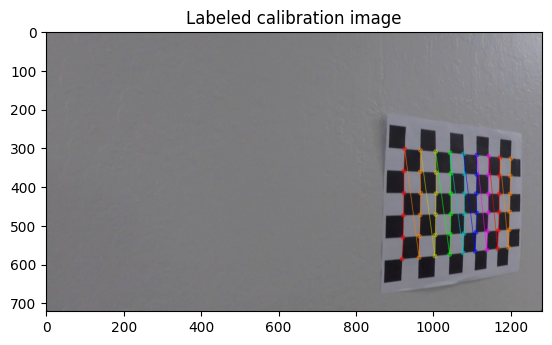

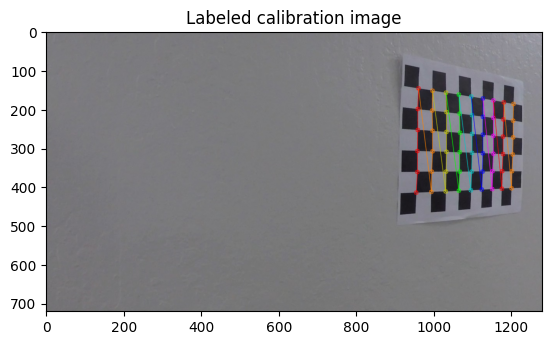

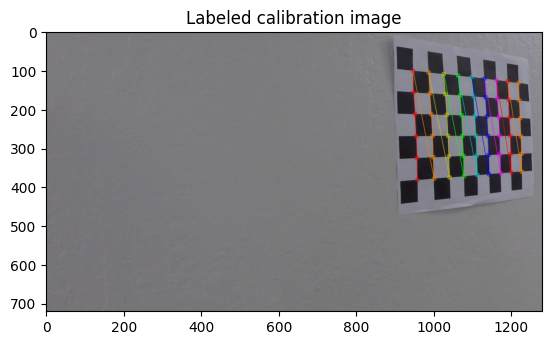

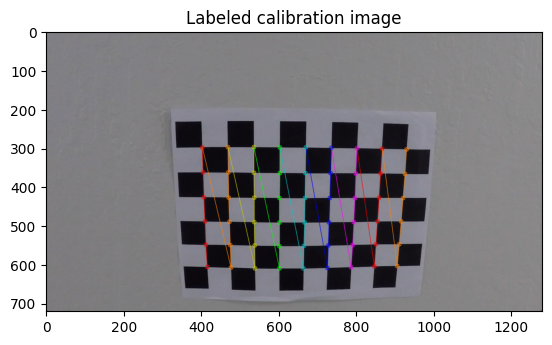

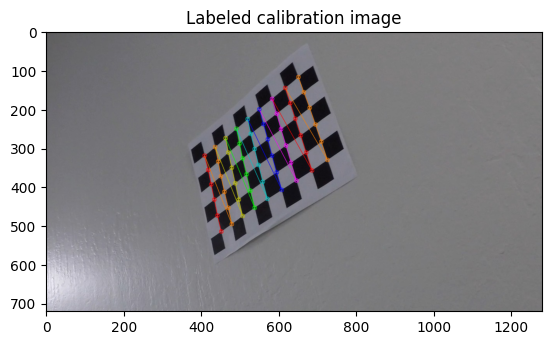

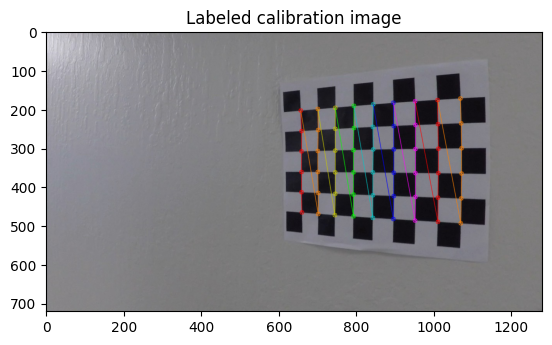

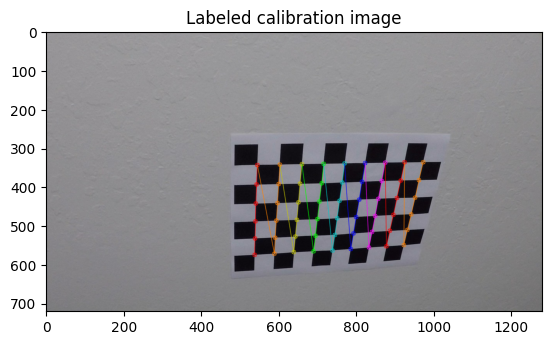

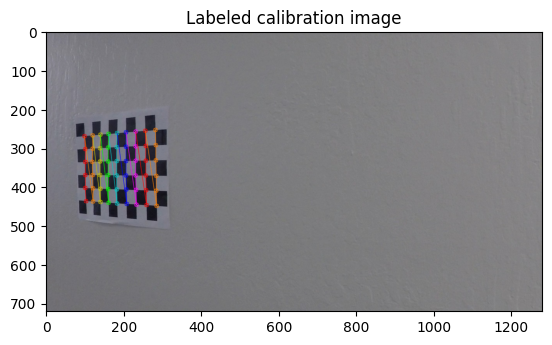

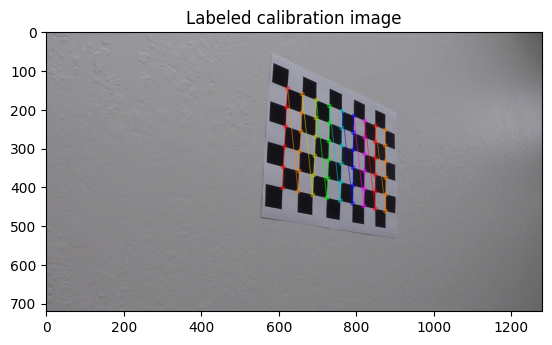

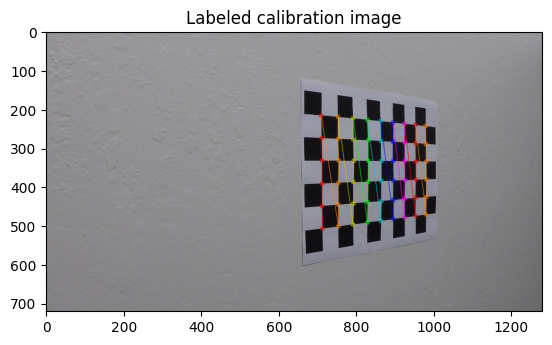

In [33]:
# Defining the dimensions of checkerboard
CHECKERBOARD = (6, 9)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = []
# images with labeled corners and undistorted images
labeled_images = []

# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

# Extracting path of individual image stored in a given directory and store in array
image_paths = glob.glob('./img/Udacity/calib/*.jpg')
IMAGES = []
for img in image_paths:
    IMAGES.append(cv.imread(img))

for img in IMAGES:
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv.findChessboardCorners(img_gray, CHECKERBOARD, cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
    
    """
    If desired number of corner are detected, we refine the pixel coordinates and display them on the images of checker board
    """
    if ret:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv.cornerSubPix(img_gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners) 
        # Draw and display the corners
        img_labeld = cv.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
        labeled_images.append(img_labeld)

"""
Performing camera calibration by passing the value of known 3D points (objpoints)
and corresponding pixel coordinates of the detected corners (imgpoints)
"""
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, img_gray.shape[::-1], None, None)

# save calculated coeffs
np.savez('calibration.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

# print calculated coeffs
print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)

# show labeld image
for img in labeled_images:
    plt.title('Labeled calibration image')
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()



### Anwendung der Kalibrierungsparameter auf Schachbrett-Testbilder
In diesem Schritt werden die berechneten Kalibierungsparameter auf die Testbilder in dem Ordner ./img/Udacity/calib angewandt.
Dabei werden die Parameter aus der Datei "calibration.npz" verwendet.

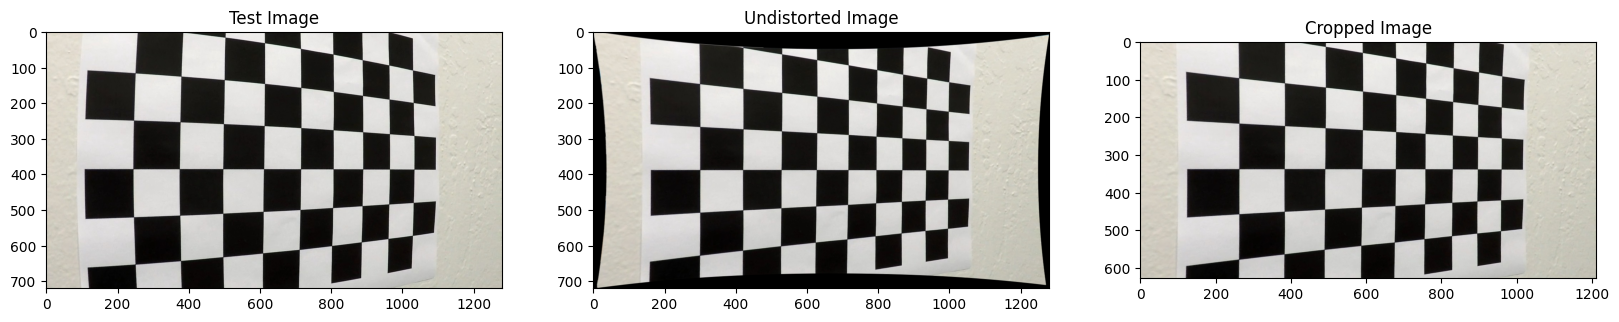

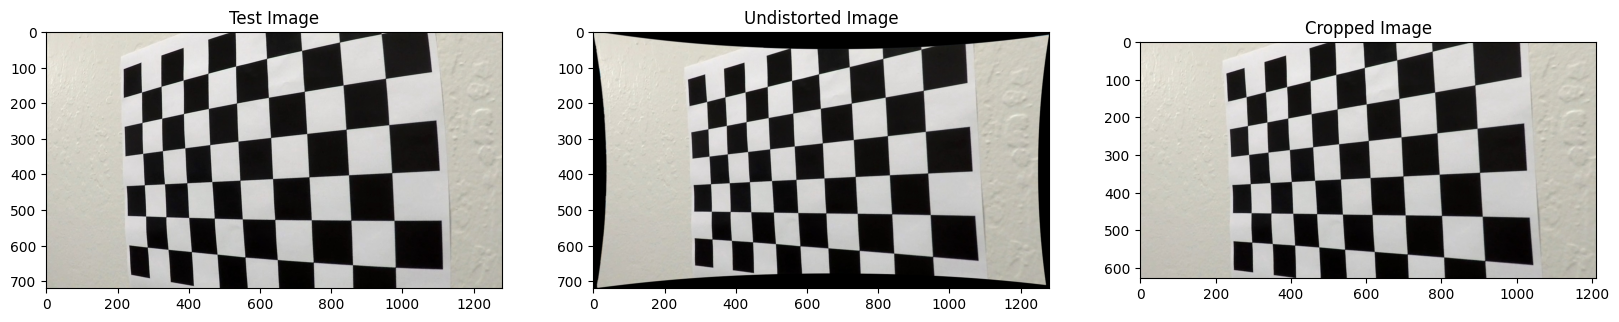

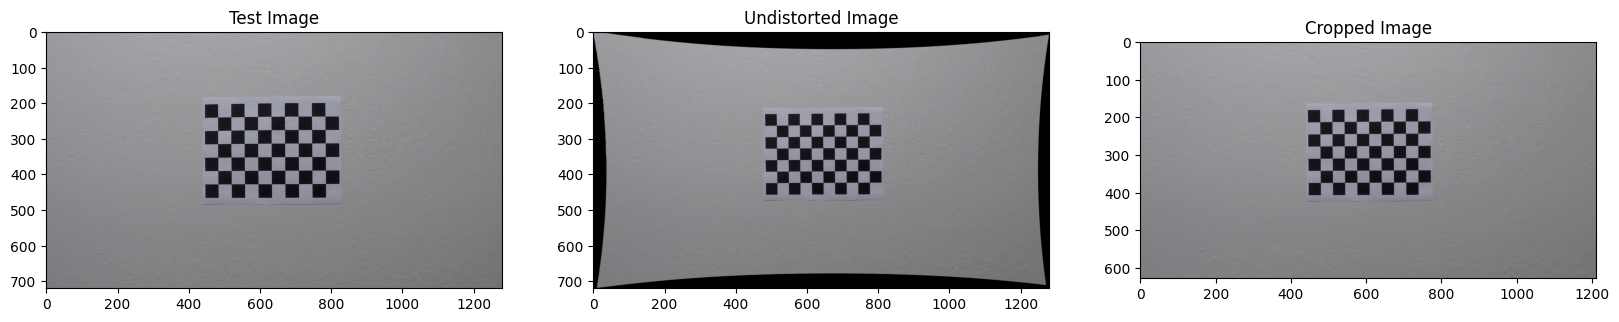

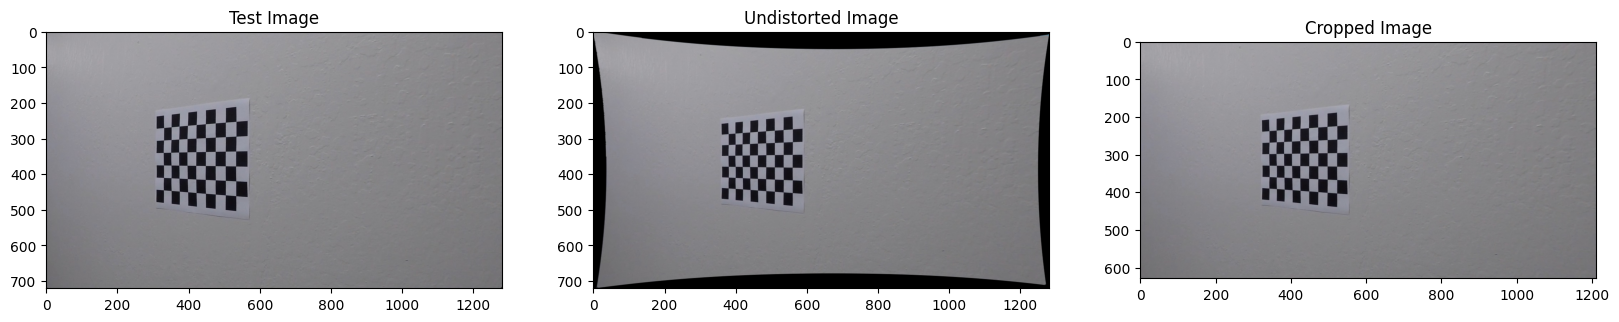

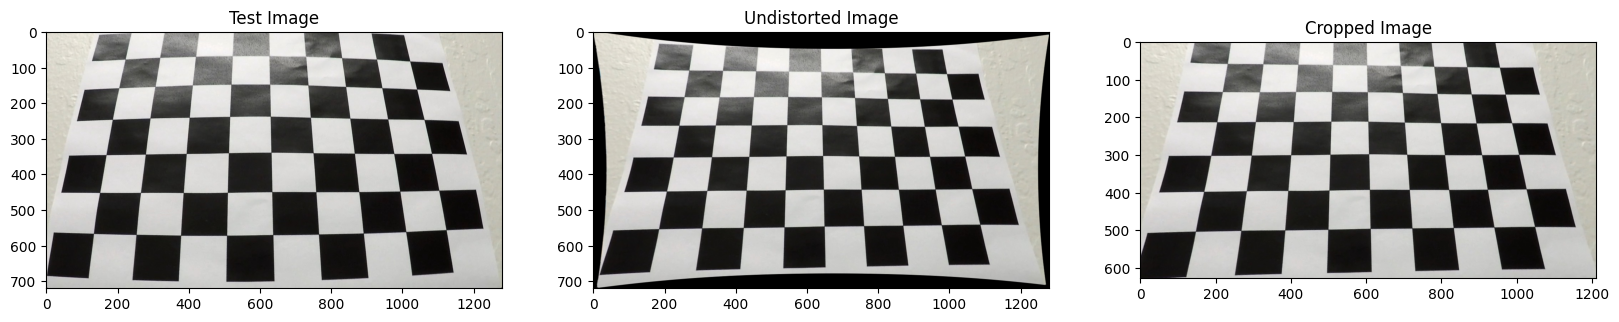

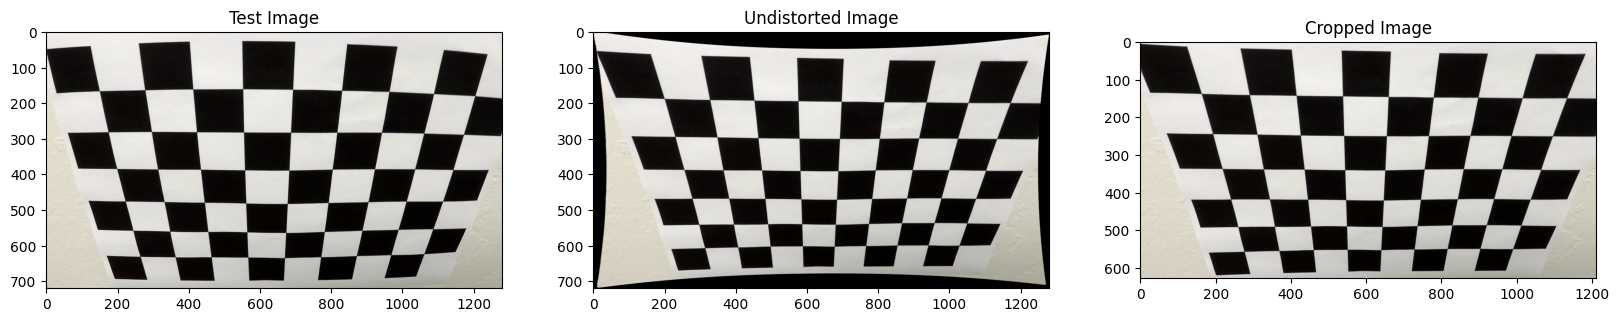

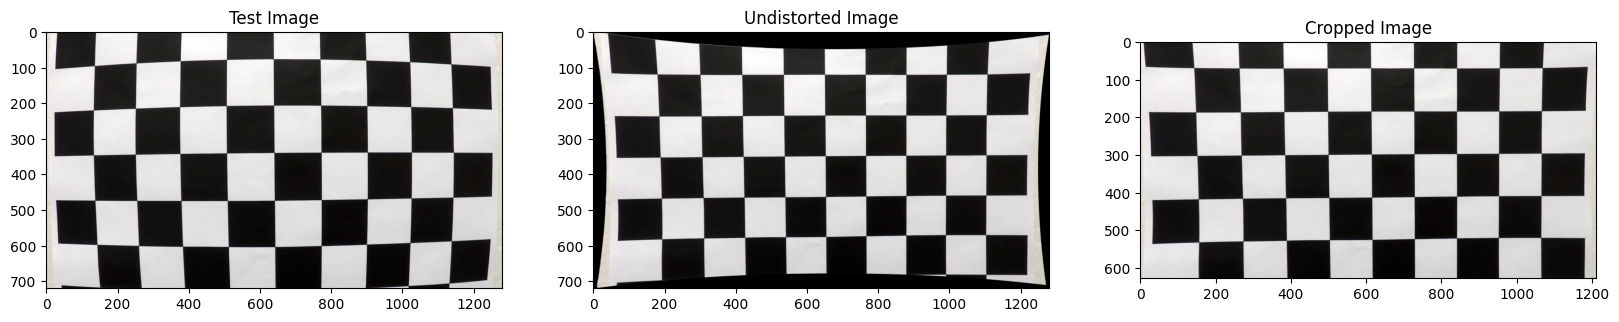

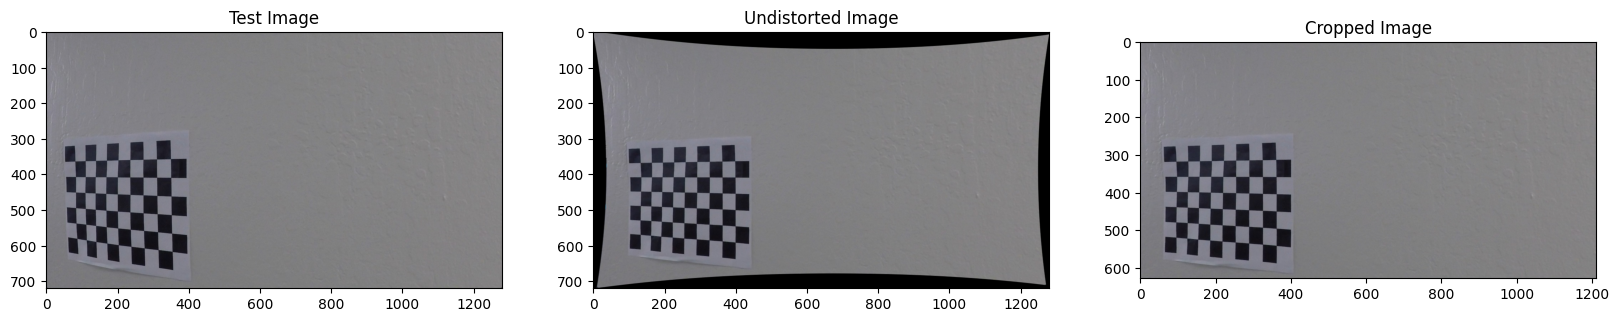

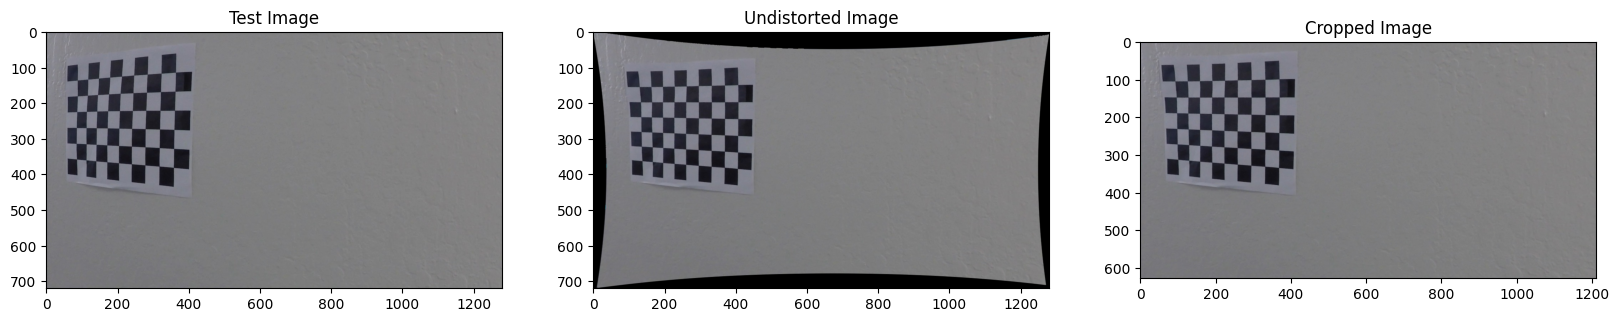

In [ ]:
# Load calibration parameters from the "calibration.npz" file
calibration_data = np.load('calibration.npz')
mtx = calibration_data['mtx']
dist = calibration_data['dist']
rvecs = calibration_data['rvecs']
tvecs = calibration_data['tvecs']

# Load test images
test_images = glob.glob('./img/Udacity/calib/*.jpg')

for img in test_images:
    # Load the test image
    test_img = cv.imread(img)

    # Undistort the image
    h, w = test_img.shape[:2]
    new_camera_mtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    undistorted_img = cv.undistort(test_img, mtx, dist, None, new_camera_mtx)
    
    # crop the image
    x, y, w, h = roi
    cropped_img = undistorted_img[y:y + h, x:x + w]
    
    # Show Testimage
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title('Test Image')
    plt.imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.title('Undistorted Image')
    plt.imshow(cv.cvtColor(undistorted_img, cv.COLOR_BGR2RGB))
    plt.subplot(1, 3, 3)
    plt.title('Cropped Image')
    plt.imshow(cv.cvtColor(cropped_img, cv.COLOR_BGR2RGB))
    plt.show()


### Anwendung der Kalibrierungsparameter auf Straßen-Testbilder
In diesem Schritt werden die berechneten Kalibierungsparameter auf die Testbilder in dem Ordner ./img/Udacity angewandt.
Dabei werden die Parameter aus der Datei "calibration.npz" verwendet.

In [ ]:
# Load calibration parameters from the "calibration.npz" file
calibration_data = np.load('calibration.npz')
mtx = calibration_data['mtx']
dist = calibration_data['dist']
rvecs = calibration_data['rvecs']
tvecs = calibration_data['tvecs']

# Load test images
test_images = glob.glob('./img/Udacity/*.jpg')

for img in test_images:
    # Load the test image
    test_img = cv.imread(img)

    # Undistort the image
    h, w = test_img.shape[:2]
    new_camera_mtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    undistorted_img = cv.undistort(test_img, mtx, dist, None, new_camera_mtx)
    
    # crop the image
    x, y, w, h = roi
    cropped_img = undistorted_img[y:y + h, x:x + w]
    
    # Show Testimage
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title('Test Image')
    plt.imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.title('Undistorted Image')
    plt.imshow(cv.cvtColor(undistorted_img, cv.COLOR_BGR2RGB))
    plt.subplot(1, 3, 3)
    plt.title('Cropped Image')
    plt.imshow(cv.cvtColor(cropped_img, cv.COLOR_BGR2RGB))
    plt.show()


## Farbräume, Histogramme
erkennen Sie die Spurmarkierungen in den Farben der angegebenen Quellen
Falls weitere Spurmarkierungen auf dem Bild gefunden werden, müssen die der eigenen Fahrspur priorisiert werden

In [ ]:
# TODO: Implementieren Sie hier Ihre Lösung für die Erkennung der Spurmarkierungen

## Curve / Polynom Fitting
- Erkennen Sie die Krümmung der Fahrspur und geben Sie diese im Ausgabebild aus
- Validierung des Verfahrens: Umrechnung auf Straßenkrümmung, sodass Simulation erfolgreich bestanden wird

In [ ]:
# TODO: Implementieren Sie hier Ihre Lösung für die Erkennung der Spurmarkierungen

## Allgemeines
Beschleunigen Sie die Verarbeitung durch weitere Maßnahmen (bspw. Erkennung der Spurmarkierung in den
ersten Frames, Tracking der Spurmarkierung in weiteren Frames solange, bis sich Spurmarkierungspositionen zu stark ändern) 
mind. eine Maßnahme im Projekt verwenden

In [ ]:
# TODO: Implementieren Sie hier Ihre Lösung für die Erkennung der Spurmarkierungen

## Allgemeines: Udacity-Bilder und Video
 relevante Spurmarkierungen werden in den Udacity-Bildern und im Video „project_video“ durchgehend erkannt

In [ ]:
# TODO: Implementieren Sie hier Ihre Lösung für die Erkennung der Spurmarkierungen